Initial Grid:


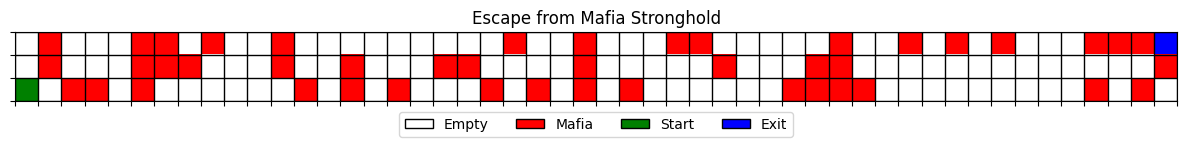

Generation 0: Best Fitness = 200
Generation 10: Best Fitness = 400
Generation 20: Best Fitness = 1020
Escape successful in generation 20!
Escaped in 68 steps

Final Results:
Best Fitness: 1020
Escape successful in 68 steps

Simulation completed in 0.19 seconds


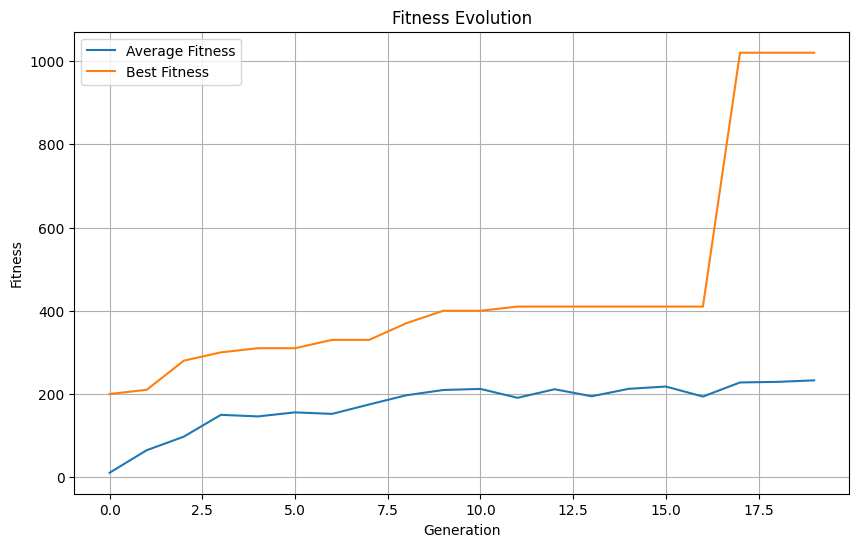


Best Solution Path (grid positions):
[(2, 0), (2, 0), (1, 0), (0, 0), (0, 0), (0, 2), (0, 2), (0, 4), (0, 4), (0, 3), (0, 2), (0, 3), (0, 3), (1, 3), (1, 3), (1, 3), (1, 4), (1, 4), (1, 4), (2, 4), (2, 4), (2, 4), (2, 4), (2, 6), (2, 8), (2, 9), (2, 11), (2, 11), (2, 11), (2, 11), (2, 13), (2, 15), (0, 15), (0, 15), (0, 17), (0, 18), (0, 20), (0, 22), (0, 22), (0, 23), (0, 25), (1, 25), (1, 25), (1, 27), (1, 29), (1, 29), (1, 29), (1, 31), (1, 33), (1, 33), (1, 33), (0, 33), (0, 34), (0, 36), (0, 36), (1, 36), (1, 38), (1, 38), (1, 39), (2, 39), (2, 41), (2, 41), (2, 43), (2, 44), (2, 44), (2, 45), (2, 47), (2, 49), (0, 49)]

Actions taken:
Step 1: Jump
Step 2: Jump
Step 3: Dash
Step 4: Dash
Step 5: Backward
Step 6: Backward
Step 7: Forward
Step 8: Step Down
Step 9: Forward
Step 10: Step Down
Step 11: Dash
Step 12: Dash
Step 13: Forward
Step 14: Dash
Step 15: Dash
Step 16: Dash
Step 17: Super Jump
Step 18: Dash
Step 19: Forward
Step 20: Dash
Step 21: Dash
Step 22: Forward
Step 23: Das

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import time

# Constants
GRID_ROWS = 3
GRID_COLS = 50
MAFIA_PERCENTAGE = 0.3
MAX_MOVES = 70
POPULATION_SIZE = 100
GENERATIONS = 100
MUTATION_RATE = 0.1  # 10% mutation rate (adjustable between 5-25%)
TOURNAMENT_SIZE = 5
ELITE_SIZE = 2

# Actions
ACTIONS = {
    0: 'Forward',      # Move one step right
    1: 'Backward',     # Move one step left
    2: 'Jump',         # Move one step up (above)
    3: 'Step Down',    # Move one step down (below)
    4: 'Super Jump',   # Move two steps up
    5: 'Dash'          # Move two steps right
}

# Movement delta for each action [row_change, col_change]
MOVE_DELTA = {
    0: [0, 1],    # Forward
    1: [0, -1],   # Backward
    2: [-1, 0],   # Jump
    3: [1, 0],    # Step Down
    4: [-2, 0],   # Super Jump
    5: [0, 2]     # Dash
}

class Grid:
    def __init__(self):
        self.grid = np.zeros((GRID_ROWS, GRID_COLS))
        self.start_pos = (2, 0)  # Bottom-left
        self.exit_pos = (0, 49)  # Top-right
        self.initialize_grid()
        
    def initialize_grid(self):
        # Place mafia members (30% of grid)
        mafia_count = int(GRID_ROWS * GRID_COLS * MAFIA_PERCENTAGE)
        positions = []
        
        # Add all positions except start and exit
        for r in range(GRID_ROWS):
            for c in range(GRID_COLS):
                if (r, c) != self.start_pos and (r, c) != self.exit_pos:
                    positions.append((r, c))
        
        # Randomly select positions for mafia
        mafia_positions = random.sample(positions, mafia_count)
        
        # Place mafia on the grid (value 1 represents mafia)
        for r, c in mafia_positions:
            self.grid[r, c] = 1
    
    def is_valid_move(self, pos):
        r, c = pos
        # Check if position is within grid bounds
        if r < 0 or r >= GRID_ROWS or c < 0 or c >= GRID_COLS:
            return False
        # Check if position has a mafia member
        if self.grid[r, c] == 1:
            return False
        return True
    
    def display(self):
        """Display the grid without any solution path overlay."""
        display_grid = self.grid.copy()
        
        # Mark start and exit positions
        display_grid[self.start_pos] = 2  # Start
        display_grid[self.exit_pos] = 3   # Exit
        
        # Create a custom colormap
        cmap = ListedColormap(['white', 'red', 'green', 'blue'])
        
        plt.figure(figsize=(15, 3))
        plt.imshow(display_grid, cmap=cmap)
        plt.grid(True, which='both', color='black', linewidth=1)
        plt.xticks(np.arange(-.5, GRID_COLS, 1), [])
        plt.yticks(np.arange(-.5, GRID_ROWS, 1), [])
        
        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='white', edgecolor='black', label='Empty'),
            Patch(facecolor='red', edgecolor='black', label='Mafia'),
            Patch(facecolor='green', edgecolor='black', label='Start'),
            Patch(facecolor='blue', edgecolor='black', label='Exit')
        ]
        plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)
        
        plt.title('Escape from Mafia Stronghold')
        plt.show()

class Individual:
    def __init__(self, gene_length=MAX_MOVES):
        # Initialize with a random action sequence
        self.genes = [random.randint(0, len(ACTIONS) - 1) for _ in range(gene_length)]
        self.fitness = 0
        self.path = []
        self.valid_actions = []  # Records only moves that change position
        self.steps_taken = 0
        self.escaped = False
    
    def calculate_fitness(self, grid):
        """Calculate fitness based on distance from exit and escape efficiency."""
        current_pos = grid.start_pos
        self.path = [current_pos]
        self.valid_actions = []  # Reset valid actions each evaluation
        self.steps_taken = 0
        self.escaped = False
        
        for action in self.genes:
            delta = MOVE_DELTA[action]
            new_pos = (current_pos[0] + delta[0], current_pos[1] + delta[1])
            
            # Check if the move is valid
            if grid.is_valid_move(new_pos):
                current_pos = new_pos
                self.path.append(current_pos)
                self.valid_actions.append(action)  # Record effective moves only
                self.steps_taken += 1
                
                # Check if exit reached
                if current_pos == grid.exit_pos:
                    self.escaped = True
                    break
            else:
                # Count the move even if invalid (position unchanged)
                self.path.append(current_pos)
                self.steps_taken += 1
        
        # Calculate Manhattan distance from exit
        exit_distance = abs(current_pos[0] - grid.exit_pos[0]) + abs(current_pos[1] - grid.exit_pos[1])
        
        if self.escaped:
            self.fitness = 1000 + (MAX_MOVES - self.steps_taken) * 10
        else:
            max_distance = GRID_ROWS + GRID_COLS
            distance_score = (max_distance - exit_distance) * 10
            self.fitness = distance_score
            if self.steps_taken >= MAX_MOVES:
                self.fitness -= 100
        
        return self.fitness

class GeneticAlgorithm:
    def __init__(self, grid):
        self.grid = grid
        self.population = [Individual() for _ in range(POPULATION_SIZE)]
        self.best_individual = None
        self.best_fitness = 0
        self.generation = 0
        self.average_fitness_history = []
        self.best_fitness_history = []
    
    def evaluate_population(self):
        """Evaluate fitness for each individual and update the best found."""
        for individual in self.population:
            fitness = individual.calculate_fitness(self.grid)
            if fitness > self.best_fitness:
                self.best_fitness = fitness
                self.best_individual = individual
    
    def tournament_selection(self):
        """Select an individual using tournament selection."""
        tournament = random.sample(self.population, TOURNAMENT_SIZE)
        return max(tournament, key=lambda ind: ind.fitness)
    
    def crossover(self, parent1, parent2):
        """Generate a child via one-point crossover."""
        child = Individual()
        crossover_point = random.randint(0, MAX_MOVES - 1)
        child.genes = parent1.genes[:crossover_point] + parent2.genes[crossover_point:]
        return child
    
    def mutate(self, individual):
        """Mutate an individual's genes with a given mutation rate."""
        for i in range(len(individual.genes)):
            if random.random() < MUTATION_RATE:
                individual.genes[i] = random.randint(0, len(ACTIONS) - 1)
    
    def evolve(self):
        """Evolve the population for one generation."""
        self.generation += 1
        self.evaluate_population()
        avg_fitness = sum(ind.fitness for ind in self.population) / POPULATION_SIZE
        self.average_fitness_history.append(avg_fitness)
        self.best_fitness_history.append(self.best_fitness)
        
        new_population = []
        sorted_population = sorted(self.population, key=lambda ind: ind.fitness, reverse=True)
        new_population.extend(sorted_population[:ELITE_SIZE])
        
        while len(new_population) < POPULATION_SIZE:
            parent1 = self.tournament_selection()
            parent2 = self.tournament_selection()
            child = self.crossover(parent1, parent2)
            self.mutate(child)
            new_population.append(child)
        
        self.population = new_population
    
    def run_simulation(self, verbose=True):
        """Run the genetic algorithm simulation over multiple generations."""
        self.population = [Individual() for _ in range(POPULATION_SIZE)]
        self.evaluate_population()
        
        if verbose:
            print(f"Generation 0: Best Fitness = {self.best_fitness}")
        
        for gen in range(1, GENERATIONS + 1):
            self.evolve()
            if verbose and gen % 10 == 0:
                print(f"Generation {gen}: Best Fitness = {self.best_fitness}")
                if self.best_individual and self.best_individual.escaped:
                    print(f"Escape successful in generation {gen}!")
                    print(f"Escaped in {self.best_individual.steps_taken} steps")
                    break
        
        if verbose:
            print("\nFinal Results:")
            print(f"Best Fitness: {self.best_fitness}")
            if self.best_individual and self.best_individual.escaped:
                print(f"Escape successful in {self.best_individual.steps_taken} steps")
            else:
                print("No successful escape found")
    
    def plot_fitness_history(self):
        """Plot the evolution of fitness over generations."""
        plt.figure(figsize=(10, 6))
        plt.plot(range(self.generation), self.average_fitness_history, label="Average Fitness")
        plt.plot(range(self.generation), self.best_fitness_history, label="Best Fitness")
        plt.xlabel("Generation")
        plt.ylabel("Fitness")
        plt.title("Fitness Evolution")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def get_solution_path(self):
        """Return the path and effective actions (only valid moves) of the best individual."""
        if not self.best_individual:
            return None, None
        
        path = self.best_individual.path
        actions = [ACTIONS[gene] for gene in self.best_individual.valid_actions]
        return path, actions

def main():
    # Create the grid and display the initial setup (without solution path)
    grid = Grid()
    print("Initial Grid:")
    grid.display()
    
    # Run the genetic algorithm simulation
    ga = GeneticAlgorithm(grid)
    start_time = time.time()
    ga.run_simulation()
    end_time = time.time()
    
    print(f"\nSimulation completed in {end_time - start_time:.2f} seconds")
    ga.plot_fitness_history()
    
    # Retrieve and print the best solution path and effective actions
    path, actions = ga.get_solution_path()
    if path:
        print("\nBest Solution Path (grid positions):")
        print(path)
        
        print("\nActions taken:")
        for i, action in enumerate(actions):
            print(f"Step {i+1}: {action}")

if __name__ == "__main__":
    main()
